In [1]:
using DynamicalSystems, DifferentialEquations, OrdinaryDiffEq,StaticArrays, Statistics,  CairoMakie

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2,  el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

Hs(x) = Statistics.mean(x) + 6 * Statistics.std(x)

function Tr(x, drop_size = 2)
    println("variable before truncate length: ", length(x)); flush(stdout)
    x = x[floor(Int, length(x) / drop_size):end ]
    println("variable  after truncate length: ", length(x)); flush(stdout)
    return x
end


function calc_number_EEs(x)
    threshold = Hs(x)
    counts = length(x[x.>=threshold])
    return counts
end;

In [555]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.12; k2 = 0.39
k = 0.0
tspan = (0.0, 50000.0)
dt = 0.001
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
condition = SA[-0.1, -0.1, -0.1, -0.6, -0.1, -0.1]

6-element SVector{6, Float64} with indices SOneTo(6):
 -0.1
 -0.1
 -0.1
 -0.6
 -0.1
 -0.1

In [556]:
# quasi
# k1 = -0.12; k = 0.39
# k = 0

In [557]:
println("number of points with tspan [$(tspan[1]); $(tspan[2])] and dt = $dt - ", length( range( tspan[1], tspan[2], step = dt ) )  )

number of points with tspan [0.0; 50000.0] and dt = 0.001 - 50000001


In [558]:
prob = ODEProblem(HR, condition, tspan, p)
sol = solve(prob,Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);

In [559]:
xsum = sol[1, :] + sol[4, :];
xsum = Tr(xsum)

Hs_ = Hs(xsum)

ysum = sol[2, :] + sol[5, :]
ysum = Tr(ysum);
zsum = sol[3, :] + sol[6, :]
zsum = Tr(zsum);

variable before truncate length: 1383959
variable  after truncate length: 691981
variable before truncate length: 1383959
variable  after truncate length: 691981
variable before truncate length: 1383959
variable  after truncate length: 691981


In [560]:
ts, tf = 696402, 702502

(696402, 702502)

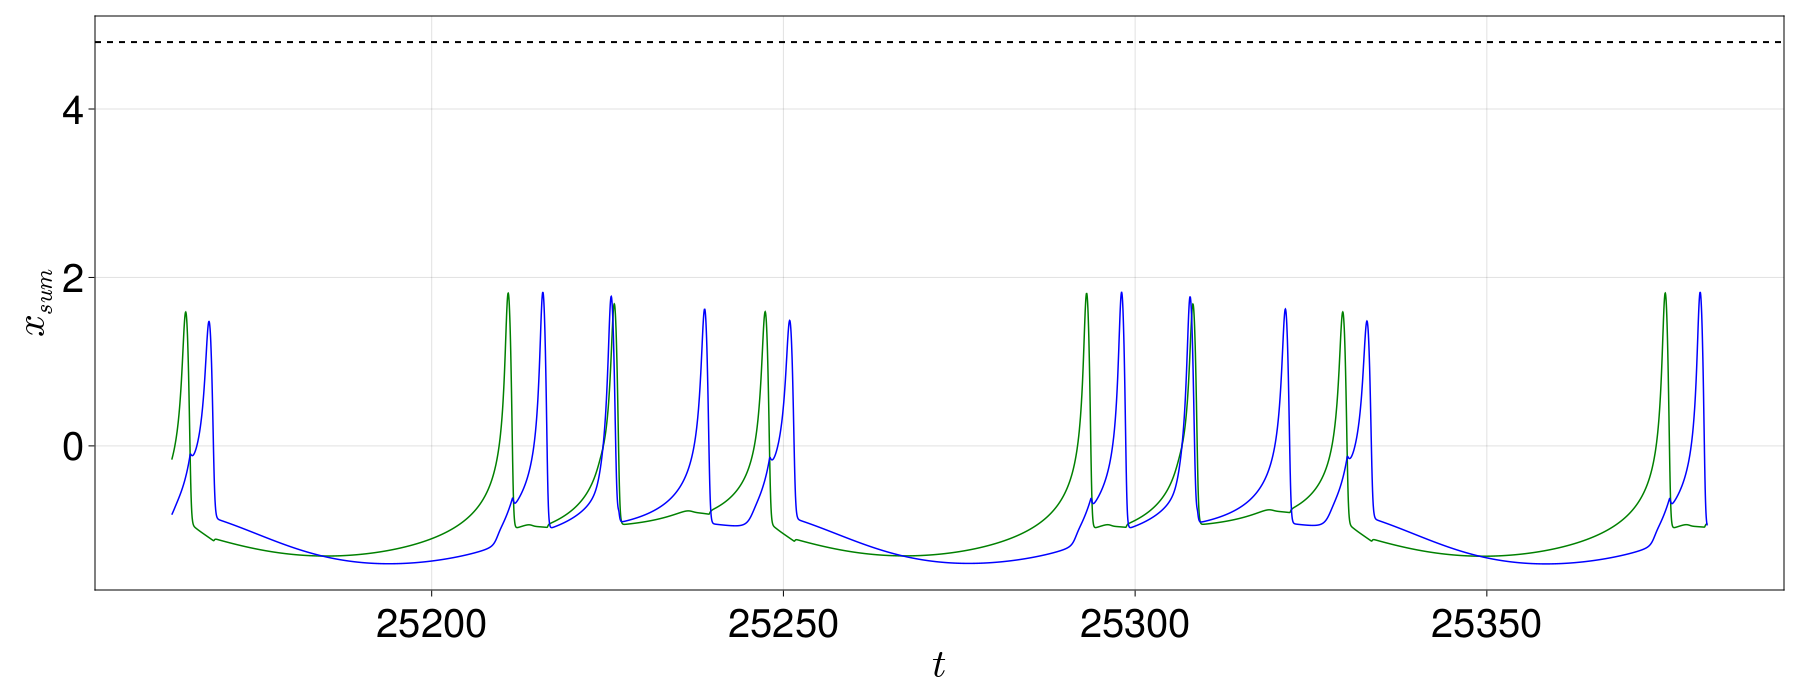

In [561]:
f = Figure(resolution = (1800, 700), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
lines!(ax, sol.t[ts:tf], sol[1, ts:tf], linewidth = 1.5, color = "green")
lines!(ax, sol.t[ts:tf], sol[4,ts:tf], linewidth = 1.5, color = "blue")
hlines!(Hs_, color = "black", linewidth = 2.0, linestyle = :dash)
f

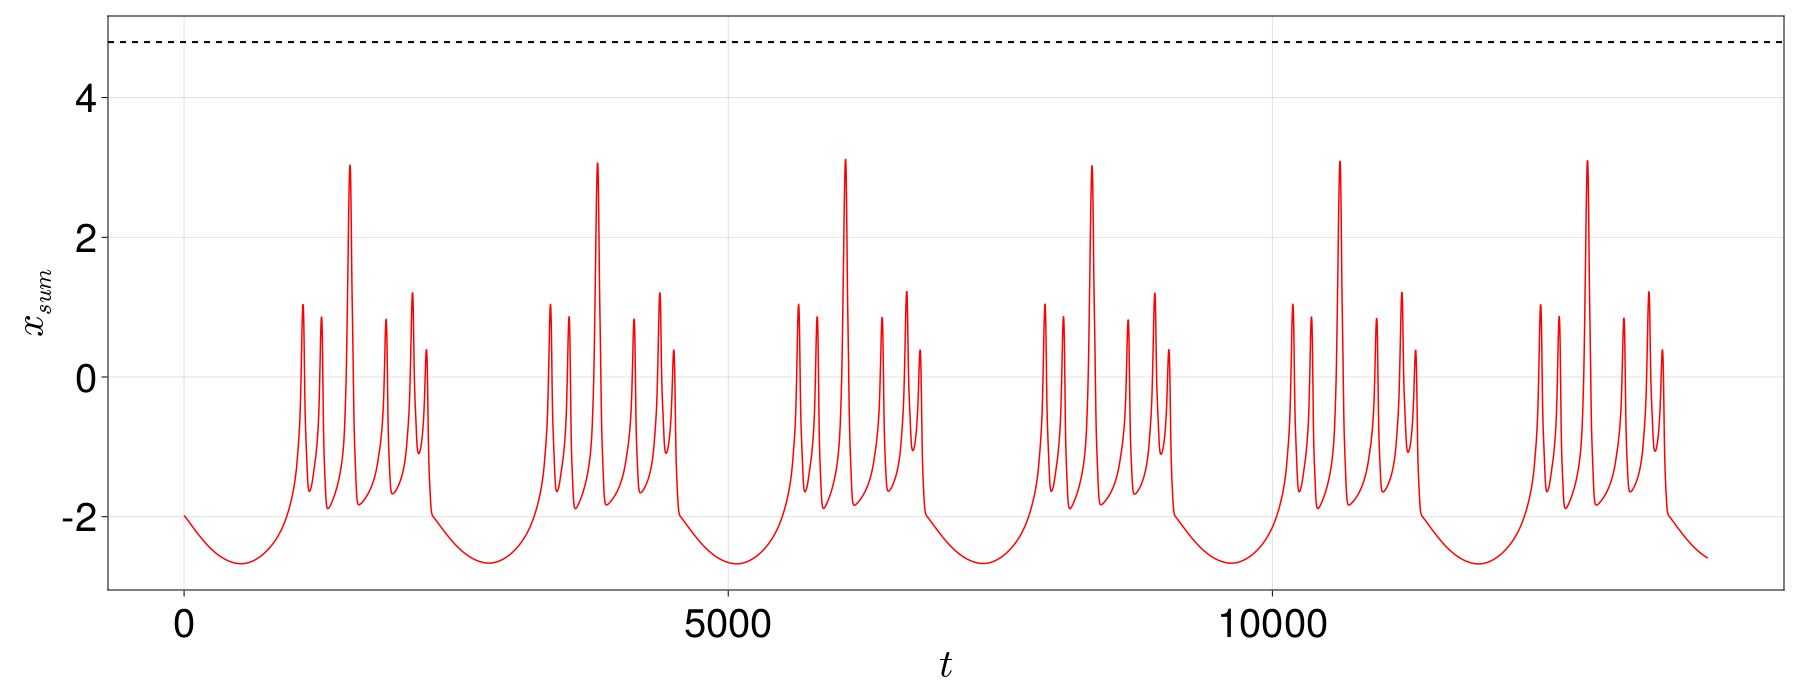

In [562]:
f = Figure(resolution = (1800, 700), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
lines!(ax, xsum[650122:664122], linewidth = 1.5, color = "red")

hlines!(Hs_, color = "black", linewidth = 2.0, linestyle = :dash)
f

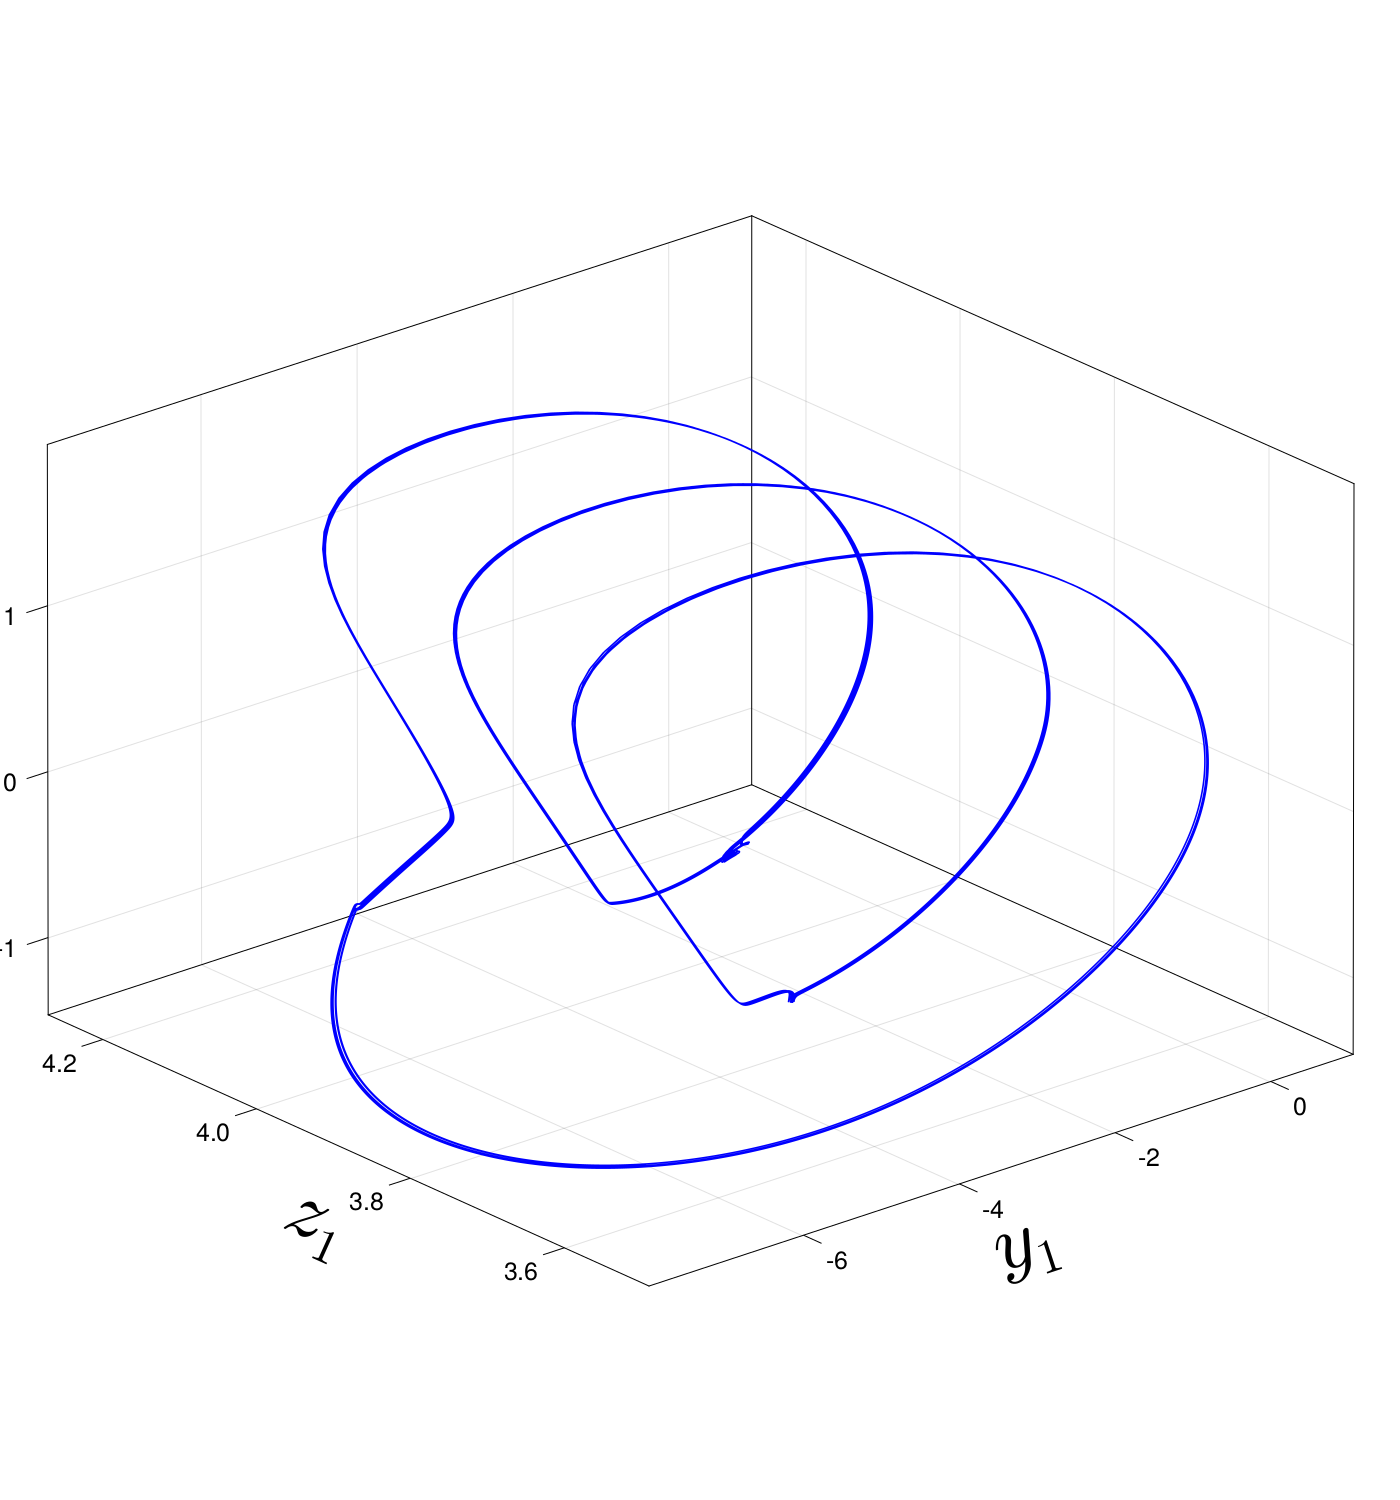

In [563]:
fv = 2
sv = 3
tv = 1
ts, tf = 200000, 220000

f = Figure(resolution = (1400, 1500))
ax = Axis3(f[1, 1],
xlabel = L"y_1", ylabel = L"z_1", zlabel = L"x_1",
xlabelsize = 80, ylabelsize = 80, zlabelsize = 80,
xticklabelsize = 25, yticklabelsize = 25, zticklabelsize = 25)

lines!(ax, sol[fv, ts:tf], sol[sv, ts:tf], sol[tv, ts:tf], linewidth = 1.5, color = "blue" )
f

In [564]:
ds = ContinuousDynamicalSystem(HR, condition, p)
LES = lyapunovspectrum(ds, tspan[2]; Ttr = tspan[2]/2, Δt = 1,
                            diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000))   

6-element Vector{Float64}:
   1.5347667493498653e-5
  -8.076883788310538e-5
  -0.0003187506553524596
  -0.0026705308408274016
  -7.554985790421279
 -10.675490828650098